In [116]:
from generator_model import Generator
from torch import optim
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader
from dataset import MapDataset
import config
from tqdm import tqdm

gen = Generator(in_channels=3)
checkpoint = torch.load("/Users/mohamedmafaz/Downloads/gen.pth.tar", map_location=torch.device(config.DEVICE))
gen.load_state_dict(checkpoint['state_dict'])
optimizer = optim.Adam(gen.parameters())
optimizer.load_state_dict(checkpoint['optimizer'])

/var/folders/3p/xlr6tgyx4t980qpxnnrs12kc0000gn/T/ipykernel_21772/2650637216.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/Users/mohamedmafaz

In [106]:
image_pth = "data/maps/val/1.jpg"
input = np.array(Image.open(image_pth))[:, :600, ...]
target = np.array(Image.open(image_pth))[:, 600:, ...]

In [128]:
val_dataset = MapDataset(root_dir=config.VAL_DIR)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

all = {"x": [], "y": [], "y_fake": []}

# x, y = next(iter(val_loader))

per = 25
for idx, (x,y) in tqdm(enumerate(val_loader)):
    if idx == per: break
    x, y = x.to(config.DEVICE), y.to(config.DEVICE)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5
        y = y * 0.5 + 0.5
        x = x * 0.5 + 0.5
    all["x"].append(x)
    all["y"].append(y)
    all["y_fake"].append(y_fake)
    

25it [00:03,  6.44it/s]


In [108]:
def convert(x):
    return np.moveaxis(np.array(x[0, :, :, :]), 0, -1)

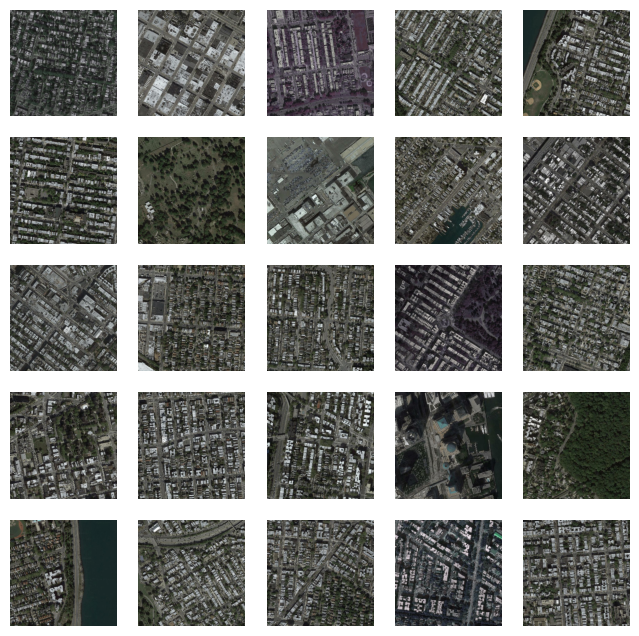

In [131]:
fig = plt.figure(figsize=(8, 8))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    img = convert(all['x'][i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis("off")


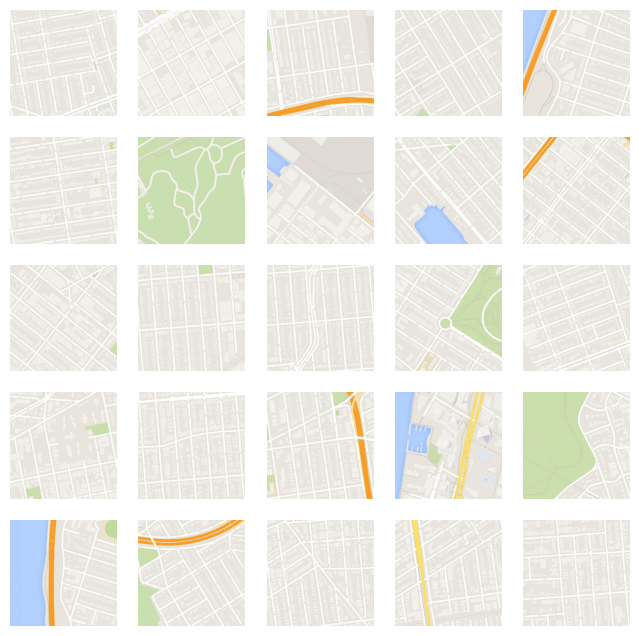

In [137]:
fig = plt.figure(figsize=(8, 8))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    img = convert(all['y'][i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis("off")


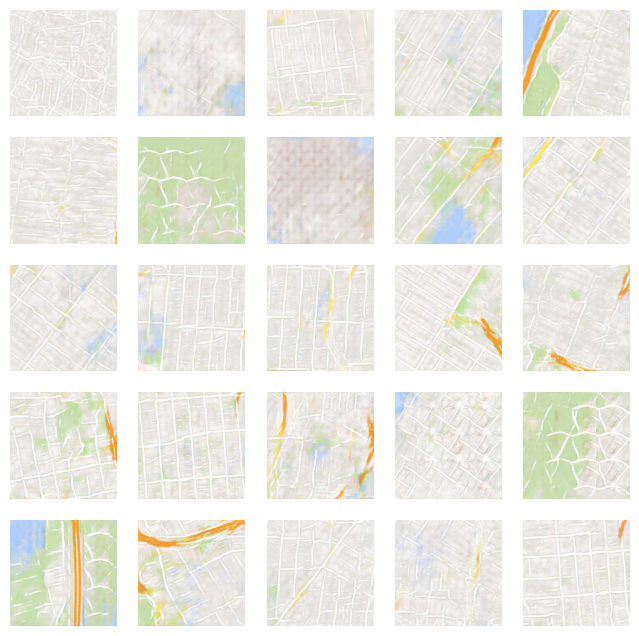

In [139]:
fig = plt.figure(figsize=(8, 8))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    img = convert(all['y_fake'][i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis("off")